In [ ]:
%pip install pandas seaborn geopandas bokeh jupyter_bokeh

### Aggregate Biodiversity in the United States 
#### (Including Alaska and Hawaii, excluding minor territories)

In [13]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from bokeh.layouts import layout
from bokeh.io import output_notebook
from bokeh.models import CustomJS, LinearAxis, Range1d
from bokeh.plotting import figure, show, save, output_file
from bokeh.models import HoverTool, RangeSlider

Using the Simpson Diversity Index formula where 0 represents no diversity and 1 represents infinite diversity:

$D = 1 - \sum^R_{i=1} (\dfrac {n_i(n_i-1)}{N(N-1)})$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [3]:
def simpson_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()

  if total_individuals == 1:
    return 0 # Only one species exists, no diversity

  for _, species, count in df.itertuples():
    sum += ((count) * (count - 1)) / (total_individuals * (total_individuals - 1))

  return 1 - sum

Using the Shannon-Wiener Diversity Index

$H' = \frac {N ln \ N -\sum (n_i ln \ n_i)}{N}$

Formula sourced from: [Libretexts](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Natural_Resources_Biometrics_(Kiernan)/10%3A_Quantitative_Measures_of_Diversity_Site_Similarity_and_Habitat_Suitability/10.01%3A_Introduction__Simpsons_Index_and_Shannon-Weiner_Index#title)

In [4]:
def shannon_diversity(df: pd.DataFrame, spec_col: str, count_col: str) -> float:
  sum = 0
  total_individuals = df[count_col].sum()
  for _, species, count in df.itertuples():
    sum += count * np.log(count)

  return ((total_individuals * np.log(total_individuals)) - (sum)) / total_individuals

Test Diversity Index functions

In [5]:
test_df = pd.DataFrame({
  'Species': ['Sugar Maple', 'Beech', 'Yellow Birch'],
  'No. of individuals': [35, 19, 11]
})

# This should output something close to 0.6053
print(simpson_diversity(test_df, 'Species', 'No. of individuals'))

# This should output soomething close to 0.993
print(shannon_diversity(test_df, 'Species', 'No. of individuals'))

0.6052884615384615
0.9934892582483463


### Aggregate biodiversity in the United States by year

In [6]:
# Import occurrences shapefile

occurrence_gdf = gpd.read_file(Path('../output/occurrences/occurrences.shp'))

In [7]:
# Prepare a dataframe for the chart

chart_gdf = occurrence_gdf

years = chart_gdf['year'].unique()

columns = {
  'year': [],
  'simpson_biodiversity': [],
  'shannon_biodiversity': [],
}

for _, year in enumerate(years):
  year_occurrences = chart_gdf[chart_gdf['year'] == year]

  columns['year'].append(year)
  columns['simpson_biodiversity'].append(
    simpson_diversity(year_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
  )
  columns['shannon_biodiversity'].append(
    shannon_diversity(year_occurrences['verbatName'].value_counts().reset_index(), 'verbatName', 'count')
  )

biodiversity_df = pd.DataFrame(data=columns).sort_values(by='year')

<Axes: xlabel='year', ylabel='shannon_biodiversity'>

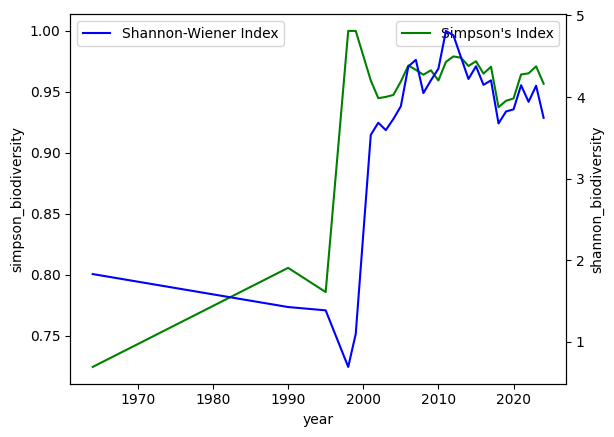

In [8]:
# Using code from https://stackoverflow.com/questions/47591650/second-y-axis-time-series
# Plot both biodiversity indicies over time on a lineplot
ax = sns.lineplot(data=biodiversity_df, x='year', y='simpson_biodiversity', color="g", label='Simpson\'s Index')
ax2 = plt.twinx()

sns.lineplot(data=biodiversity_df, x='year', y='shannon_biodiversity', color="b", ax=ax2, label='Shannon-Wiener Index')

Code for the Twin Axes chart was derived from the Bokeh documentation: [Bokeh API](https://docs.bokeh.org/en/latest/docs/user_guide/basic/axes.html#twin-axes)

Code for the range slider was derived from the Bokeh documentation: [Bokeh API](https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html)

In [15]:
output_notebook()

Loading BokehJS ...

In [19]:
from bokeh.layouts import layout

x = biodiversity_df['year']
y = biodiversity_df['simpson_biodiversity']
y2 = biodiversity_df['shannon_biodiversity']

p = figure(
    title='Aggregate Biodiversity in the United States',
    x_range=(x.min(), x.max()), 
    y_range=(y.min(), y.max()),
    toolbar_location='left',
    width=800,
    height=800,
)

simpson_biodiversity = p.line(x, y, color="green", line_width=2, legend_label='Simpson\'s')
p.axis.axis_label = "Simpson Biodiversity"

p.xaxis.axis_label = 'Year'

p.extra_x_ranges['foo'] = Range1d(x.min(), x.max())
p.extra_y_ranges['foo'] = Range1d(y2.min(), y2.max())
shannon_biodiversity = p.line(x, y2, color="blue", line_width=2, legend_label='Shannon-Wiener',
    x_range_name="foo",
    y_range_name="foo",
)

ax2 = LinearAxis(
    axis_label="Shannon-Wiener Biodiversity",
    x_range_name="foo",
    y_range_name="foo",
)
p.add_layout(ax2, 'right')

range_slider = RangeSlider(
    title="Year Range", # a title to display above the slider
    start=p.x_range.start,  # set the minimum value for the slider
    end=p.x_range.end,  # set the maximum value for the slider
    step=1,  # increments for the slider
    value=(p.x_range.start, p.x_range.end),  # initial values for slider
)

range_slider.js_link("value", p.x_range, "start", attr_selector=0)
range_slider.js_link("value", p.x_range, "end", attr_selector=1)

range_slider.js_link("value", p.extra_x_ranges['foo'], "start", attr_selector=0)
range_slider.js_link("value", p.extra_x_ranges['foo'], "end", attr_selector=1)

p.add_tools(HoverTool(renderers=[simpson_biodiversity], attachment = 'above', tooltips=[
    ("Year", "@x"),
    ("Simpson Index", "@y"),
], mode="vline"))

p.add_tools(HoverTool(renderers=[shannon_biodiversity], attachment = 'below', tooltips=[
    ("Year", "@x"),
    ("Shannon-Wiener Index", "@y"),
], mode="vline"))

p.legend.location = 'top_left'
p.legend.title = 'Index'

layout = layout(
    [range_slider],
    [p]
)

show(layout)


In [ ]:
# Save plot to a file
output_file(filename=Path('../charts/aggregate_biodiversity.html'), title='Aggregate Biodiversity in the United States')
save(layout)